In [1]:
from platform import python_version
print(python_version())

3.7.4


In [1]:
from keras.constraints import Constraint
import keras.backend as K


#this function just clips values to a range (elementwise)
class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):        
        return K.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

Using TensorFlow backend.


In [2]:
import keras
import numpy as np
from keras import backend as K

from keras.layers import Layer
from keras.layers import activations
from keras.layers import initializers
from keras.layers import regularizers
from keras.layers import constraints


from keras.utils import to_categorical
from  keras.engine.base_layer import InputSpec
from keras.utils.generic_utils import to_list

class Tent(Layer):
    """Tent activation Unit.
    It follows:
    `f(x) =  max( 0, theta -|x|) ,

    where `theta` is a learned array with the same shape as x.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as the input.
    # Arguments
        theta_initializer: initializer function for the weights.
        theta_regularizer: L2 regularization strenth
        theta_max: highest allowed value for theta (min value is set to 0.05)
        shared_axes: the axes along which to share learnable
            parameters for the activation function.
            For example, if the incoming feature maps
            are from a 2D convolution
            with output shape `(batch, height, width, channels)`,
            and you wish to share parameters across space
            so that each filter only has one set of parameters,
            set `shared_axes=[1, 2]`.
    # References
    https://arxiv.org/pdf/1908.02435.pdf
    """

    def __init__(self,
                 theta_regularizer=0.12,
                 theta_max=1.0,
                 shared_axes=None,
                 **kwargs):
        super(Tent, self).__init__(**kwargs)
        self.supports_masking = True # Do not know what this does, just let it be
        self.theta_initializer = initializers.Ones() #see article
        self.theta_regularizer = regularizers.l2(theta_regularizer) # I interpreted "weight decay" as l2, not l1 
        self.theta_constraint = Between(min_value=0.05,max_value=theta_max)

        if shared_axes is None:
            self.shared_axes = None
        else:
            self.shared_axes = to_list(shared_axes, allow_tuple=True)

    def build(self, input_shape):
        param_shape = list(input_shape[1:])
        self.param_broadcast = [False] * len(param_shape)
        if self.shared_axes is not None:
            for i in self.shared_axes:
                param_shape[i - 1] = 1
                self.param_broadcast[i - 1] = True
        self.theta = self.add_weight(shape=param_shape,
                                     name='theta',
                                     initializer=self.theta_initializer,
                                     regularizer=self.theta_regularizer,
                                     constraint=self.theta_constraint)
        # Set input spec
        axes = {}
        if self.shared_axes:
            for i in range(1, len(input_shape)):
                if i not in self.shared_axes:
                    axes[i] = input_shape[i]
        self.input_spec = InputSpec(ndim=len(input_shape), axes=axes)
        self.built = True

    def call(self, inputs, mask=None):
        pos = K.relu(self.theta - K.abs(inputs))
        return pos 

    #TODO: what is this config for? Proabably should update this to add "theta_max"
    def get_config(self):
        config = {
            'theta_initializer': initializers.serialize(self.theta_initializer),
            'theta_regularizer': regularizers.serialize(self.theta_regularizer),
            'shared_axes': self.shared_axes
        }
        base_config = super(Tent, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

# this is MNIST

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
print(np.shape(x_train))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

(60000, 28, 28, 1)


In [4]:
print(np.mean(x_train))
print(np.max(x_train))

0.13066062
1.0


# Baseline model with Relu

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D


#baseline "MNIST_CNN" model used by the article https://arxiv.org/pdf/1908.02435.pdf
# TODO: maybe we should not realy on the TENT article as reference. We should pick a
#       well known architecture (AlexNet, VGG) and use it with all the variations we try

baseline = Sequential()
#layer1
baseline.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
#layer2
baseline.add(Conv2D(32, (3, 3)))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))

baseline.add(MaxPooling2D(pool_size=(2, 2)))

#layer3
baseline.add(Conv2D(64, (3, 3), padding='same'))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
#layer4
baseline.add(Conv2D(64, (3, 3)))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))

baseline.add(MaxPooling2D(pool_size=(2, 2)))
baseline.add(Flatten())

#layer5
baseline.add(Dense(200))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
baseline.add(Dropout(0.5))
#layer6
baseline.add(Dense(200))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
baseline.add(Dropout(0.5))

baseline.add(Dense(10))

baseline.add(Activation('softmax'))


# Let's train the model using RMSprop
baseline.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

#fit
baseline.fit(x_train, y_train, batch_size=100, epochs=40, validation_data=(x_test, y_test), shuffle=True)

#stats
print("tent mean confidence on train images ",np.mean(np.max(baseline.predict(x_train),axis=1)))
print("tent mean confidence on test images ",np.mean(np.max(baseline.predict(x_test),axis=1)))

ran = np.random.random(size=(100,28,28,1))
print("tent mean confidence on random matrix (should be uniform)",np.mean(np.max(baseline.predict(ran),axis=1)))

flat_gray=np.ones((1,28,28,1))*0.5
print("tent mean confidence on flat_gray img (should be uniform)",np.mean(np.max(baseline.predict(flat_gray),axis=1)))

avg_img = np.mean(x_test, axis=0,keepdims=True)
print("tent mean confidence on avg_img (should be uniform)",np.mean(np.max(baseline.predict(avg_img),axis=1)))




Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 9s 155us/step - loss: 0.2020 - acc: 0.9420 - val_loss: 0.0621 - val_acc: 0.9801
Epoch 2/40
60000/60000 [==============================] - 8s 129us/step - loss: 0.0658 - acc: 0.9811 - val_loss: 0.0402 - val_acc: 0.9883
Epoch 3/40
60000/60000 [==============================] - 8s 132us/step - loss: 0.0513 - acc: 0.9855 - val_loss: 0.0336 - val_acc: 0.9892
Epoch 4/40
60000/60000 [==============================] - 7s 124us/step - loss: 0.0406 - acc: 0.9877 - val_loss: 0.0271 - val_acc: 0.9916
Epoch 5/40
60000/60000 [==============================] - 8s 126us/step - loss: 0.0350 - acc: 0.9896 - val_loss: 0.0243 - val_acc: 0.9919
Epoch 6/40
60000/60000 [==============================] - 8s 131us/step - loss: 0.0327 - acc: 0.9903 - val_loss: 0.0232 - val_acc: 0.9926
Epoch 7/40
60000/60000 [==============================] - 8s 129us/step - loss: 0.0282 - acc: 0.9917 - val_loss: 0.0271 - 

In [12]:
print("baseline predictions on random (are they all the same?)",np.argmax(baseline.predict(ran),axis=1))


baseline predictions on random (are they all the same?) [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


# Next let's use TENT in all layers
TODO: give it a better model name, not overwrite "model" each time

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D


#model from article https://arxiv.org/pdf/1908.02435.pdf

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Tent(shared_axes=[0,1,2])) # only one tent width value per layer 

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Tent(shared_axes=[0,1,2]))  # only one tent width value per layer

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Tent(shared_axes=[0,1,2]))  # only one tent width value per layer

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Tent(shared_axes=[0,1,2])) # only one tent width value per layer

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Tent(shared_axes=[0])) # only one tent width value per layer
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Tent(shared_axes=[0])) # only one tent width value per layer
model.add(Dropout(0.5))

model.add(Dense(10)) # I suppose no TENT in here. It does not really learn with tent here

model.add(Activation('softmax'))


# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [6]:
#let's just visualize the initialized tent widhts (should be 1 value per layer, initialized to 1)
for lay in model.layers:
    if "theta_initializer" in lay.get_config():
        print(np.shape(lay.get_weights()))
        print(lay.get_weights())

output = model.predict(np.expand_dims(np.random.random(x_train.shape[1:]),0))
print("should be random (/uniform):  ", output)

(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1)
[array([1.], dtype=float32)]
(1, 1)
[array([1.], dtype=float32)]
should be random (/uniform):   [[0.09124071 0.1431169  0.1185334  0.10619537 0.1105161  0.03032977
  0.03706808 0.17415461 0.15287882 0.03596622]]


In [7]:
model.fit(x_train, y_train, batch_size=100, epochs=40, validation_data=(x_test, y_test), shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 11s 178us/step - loss: 2.7767 - acc: 0.1765 - val_loss: 2.9480 - val_acc: 0.0919
Epoch 2/40
60000/60000 [==============================] - 9s 155us/step - loss: 2.4147 - acc: 0.2031 - val_loss: 2.9314 - val_acc: 0.0932
Epoch 3/40
60000/60000 [==============================] - 9s 155us/step - loss: 2.3128 - acc: 0.2059 - val_loss: 2.8842 - val_acc: 0.0999
Epoch 4/40
60000/60000 [==============================] - 9s 156us/step - loss: 2.2742 - acc: 0.2091 - val_loss: 2.2643 - val_acc: 0.2196
Epoch 5/40
60000/60000 [==============================] - 9s 156us/step - loss: 2.2458 - acc: 0.2100 - val_loss: 3.0949 - val_acc: 0.0726
Epoch 6/40
60000/60000 [==============================] - 9s 156us/step - loss: 2.2205 - acc: 0.2170 - val_loss: 2.1846 - val_acc: 0.2240
Epoch 7/40
60000/60000 [===

In [8]:
#let's see the fitted width values - see article for what they got...
# notice this depends heavily on the regularization 
for lay in model.layers:
    if "theta_initializer" in lay.get_config():
        print(np.shape(lay.get_weights()))
        print(lay.get_weights())

(1, 1, 1, 1)
[array([[[0.23019592]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[0.23353232]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[0.18351622]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[0.18637131]]], dtype=float32)]
(1, 1)
[array([0.19555807], dtype=float32)]
(1, 1)
[array([0.29713175], dtype=float32)]


In [13]:
print("tent mean confidence on train images (compare with accuracy)",np.mean(np.max(model.predict(x_train),axis=1)))
print("tent mean confidence on test images (compare with accuracy)",np.mean(np.max(model.predict(x_test),axis=1)))


ran = np.random.random(size=(100,28,28,1))

print("tent mean confidence on random matrixes (should be uniform)",np.mean(np.max(model.predict(ran),axis=1)))
print("tent prediction on random ",np.argmax(model.predict(ran),axis=1))


flat_gray=np.ones((100,28,28,1))*0.5
print("tent mean confidence on flat_gray img (should be uniform) ",np.mean(np.max(model.predict(flat_gray),axis=1)))

avg_img = np.mean(x_test, axis=0,keepdims=True)
#print(np.shape(avg_img))
print("tent mean confidence on avg_img (should be uniform?)",np.mean(np.max(model.predict(avg_img),axis=1)))
print("\n the weights theta are")
print(np.shape(model.layers[2].get_weights()))
print(model.layers[2].get_weights())


tent mean confidence on train images (compare with accuracy) 0.9914855
tent mean confidence on test images (compare with accuracy) 0.9906426
tent mean confidence on random matrixes (should be uniform) 0.68727577
tent prediction on random  [2 8 8 2 8 8 2 8 8 8 5 8 8 8 8 8 8 0 8 0 8 8 8 8 8 0 8 8 8 2 8 8 8 8 6 0 8
 6 8 8 2 8 8 8 8 8 0 8 8 8 8 2 8 2 6 8 8 8 8 8 8 8 8 8 0 8 5 8 6 2 0 8 8 8
 0 8 8 8 8 8 8 8 8 8 2 8 8 5 8 8 2 8 0 8 5 8 8 8 8 6]
tent mean confidence on flat_gray img (should be uniform)  0.9890951
tent mean confidence on avg_img (should be uniform?) 0.5540315

 the weights theta are
(1, 1, 1, 1)
[array([[[0.23019592]]], dtype=float32)]


# Discussion
These above results are an improvement over baseline (lower confidence on random and on avg img) 
But if you train again the result varies a lot. Sometimes it's pretty mucht the same.
In any case this improvement is not enough, I think - flat gray image fails!

# Is it calibrated?
TODO: the cell below was written in hurry, copy-past+modify method. not sure it is correct. please double-check

TODO2: models were very good on val set, so I just added noise to it to generate uncertainty. Maybe there's some elegant way?

TENT model mean confidence 0.85127014
TENT model accuracy on noisy test set: 0.4712
baseline mean confidence 0.97339636
baseline accuracy on noisy test set: 0.9514


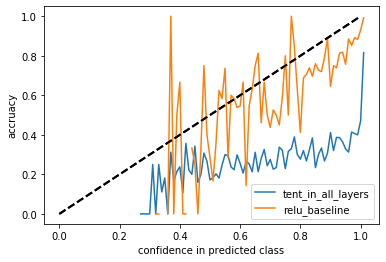

In [16]:
import matplotlib.pyplot as plt

noisy_test = x_test*0.8+np.random.random(np.shape(x_test))*0.2

all_confidences = np.max(model.predict(noisy_test),axis=1)
print("TENT model mean confidence", np.mean(all_confidences))
wasit_correct = np.argmax(y_test,axis=1)==np.argmax(model.predict(noisy_test),axis=1)
print("TENT model accuracy on noisy test set:", np.mean(wasit_correct))

order = np.argsort(all_confidences)
ordered_confidences = all_confidences[order]
ordered_wasit = wasit_correct[order]

mean_acc=[]
last_idx=0
for i in np.arange(0.16,1.01,0.01):
    stop_idx = np.searchsorted(ordered_confidences,i)
    mean_acc.append(np.mean(ordered_wasit[last_idx:stop_idx]))
    last_idx=stop_idx
    

plt.figure()
plt.plot(np.arange(0.16,1.01,0.01)+0.01,mean_acc,label="tent_in_all_layers")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.ylabel("accruacy")
plt.xlabel("confidence in predicted class")
#plt.legend()

#####################

all_confidences = np.max(baseline.predict(noisy_test),axis=1)
print("baseline mean confidence", np.mean(all_confidences))
wasit_correct = np.argmax(y_test,axis=1)==np.argmax(baseline.predict(noisy_test),axis=1)
print("baseline accuracy on noisy test set:", np.mean(wasit_correct))

order = np.argsort(all_confidences)
ordered_confidences = all_confidences[order]
ordered_wasit = wasit_correct[order]

mean_acc=[]
last_idx=0
for i in np.arange(0.16,1.01,0.01):
    stop_idx = np.searchsorted(ordered_confidences,i)
    mean_acc.append(np.mean(ordered_wasit[last_idx:stop_idx]))
    last_idx=stop_idx
    
plt.plot(np.arange(0.16,1.01,0.01)+0.01,mean_acc,label="relu_baseline")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.legend()

plt.show();


# MNIST+last layer tent only
TODO: better name, othewirse we overwrite

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D


#model from article https://arxiv.org/pdf/1908.02435.pdf

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Tent(shared_axes=[0,1,2]))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Tent(shared_axes=[0,1,2]))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Tent(shared_axes=[0,1,2]))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
#model.add(Tent(shared_axes=[0,1,2]))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(200))
model.add(BatchNormalization())
#model.add(Tent(shared_axes=[0]))
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add(Dense(200))
model.add(BatchNormalization())
#model.add(Tent(shared_axes=[0]))
model.add(Activation("relu"))
#model.add(Dropout(0.5))

model.add(Dense(10))
#Notice high theta needed here, otherwise it is impossibel to get high probabilities. 
# so I use low regularization+high max
model.add(Tent(shared_axes=[0], theta_regularizer=0.001,theta_max=15.0)) 

model.add(Activation('softmax'))


# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])


In [54]:
model.fit(x_train, y_train, batch_size=100, epochs=40, validation_data=(x_test, y_test), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 12s 197us/step - loss: 1.5140 - acc: 0.7959 - val_loss: 1.1401 - val_acc: 0.9555
Epoch 2/40
60000/60000 [==============================] - 10s 159us/step - loss: 0.9318 - acc: 0.9703 - val_loss: 0.7296 - val_acc: 0.9878
Epoch 3/40
60000/60000 [==============================] - 9s 154us/step - loss: 0.6352 - acc: 0.9806 - val_loss: 0.5089 - val_acc: 0.9888
Epoch 4/40
60000/60000 [==============================] - 9s 156us/step - loss: 0.4447 - acc: 0.9856 - val_loss: 0.3648 - val_acc: 0.9896
Epoch 5/40
60000/60000 [==============================] - 9s 156us/step - loss: 0.3218 - acc: 0.9872 - val_loss: 0.2659 - val_acc: 0.9909
Epoch 6/40
60000/60000 [==============================] - 9s 154us/step - loss: 0.2395 - acc: 0.9884 - val_loss: 0.2117 - val_acc: 0.9873
Epoch 7/40
60000/60000 [==============================] - 9s 154us/step - loss: 0.1828 - acc: 0.9899 - val_loss: 0.1486 

In [55]:
print("tent mean confidence on train images ",np.mean(np.max(model.predict(x_train),axis=1)))
print("tent mean confidence on test images ",np.mean(np.max(model.predict(x_test),axis=1)))

ran = np.random.random(size=(10,28,28,1))
print("tent prediction on random ",np.argmax(model.predict(ran),axis=1))
print("tent mean confidence on random matrix (should be uniform)",np.mean(np.max(model.predict(ran),axis=1)))

flat_gray=np.ones((1,28,28,1))*0.5
print("tent confidence on flat_gray img (should be uniform)",np.mean(np.max(model.predict(flat_gray),axis=1)))
print("tent pred flat_gray imgx ",np.argmax(model.predict(flat_gray),axis=1))

avg_img = np.mean(x_test, axis=0,keepdims=True)
#print(np.shape(avg_img))
print("tent mean confidence on avg_img (should be uniform)",np.mean(np.max(model.predict(avg_img),axis=1)))
print("\n the weights theta are")
print(np.shape(model.layers[-2].get_weights()))
print(model.layers[-2].get_weights())


tent mean confidence on train images  0.99817365
tent mean confidence on test images  0.9959659
tent predicction on random  [8 8 8 8 8 8 8 8 8 8]
tent mean confidence on random matrix  0.9991867
tent confidence on flat_gray img  0.84640956
tent pred flat_gray imgx  [1]
tent mean confidence on avg_img  0.7120763

 the weights theta are
(1, 1)
[array([9.368581], dtype=float32)]


# Visualizing activations in intermediate layers:
(to make it meaningful, one should do for all models and average, visualize somehow (histogram?)

In [56]:
print(model.layers[-2]) #last tent layer

from keras.models import Model

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-5].output)
intermediate_output = intermediate_layer_model.predict(flat_gray)
print(intermediate_output[:3])

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-4].output)
intermediate_output = intermediate_layer_model.predict(flat_gray)
print(intermediate_output[:3])

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-3].output)
intermediate_output = intermediate_layer_model.predict(flat_gray)
print(intermediate_output[:3])


intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
intermediate_output = intermediate_layer_model.predict(flat_gray)
print(intermediate_output[:3])

print(model.layers[-2].get_weights())

[[-6.98089600e-02  8.54015350e-02 -6.65393919e-02  5.23515716e-02
  -1.94934666e-01  3.65341961e-01  3.78372580e-01 -1.82424352e-01
  -1.92453265e-01 -2.51381457e-01 -2.89486408e-01  6.00317538e-01
  -1.27224207e-01  2.13604644e-01 -1.09502010e-01  7.31219769e-01
  -7.53826976e-01 -4.54864144e-01 -4.85928953e-01  7.65500903e-01
  -1.97194487e-01  8.91038835e-01  3.30345243e-01 -3.47170830e-02
   2.24707723e-01 -2.56163716e-01 -6.18660390e-01 -2.59753376e-01
  -2.47774661e-01 -9.01791304e-02  2.12570518e-01  1.98923834e-02
   8.64223599e-01  1.74429268e-01 -4.43559498e-01 -5.91391504e-01
   7.13081658e-02 -1.26860961e-01  3.62760246e-01  3.81595671e-01
   2.52822578e-01  4.50831532e-01 -6.67024255e-02 -4.09743279e-01
  -8.63886833e-01  1.03289366e-01  5.56929037e-02 -7.02638179e-03
  -4.57333446e-01 -1.59371078e-01 -2.63388336e-01 -4.92135763e-01
   4.66339052e-01  3.02299529e-01  2.84311354e-01 -4.22149539e-01
  -1.85074866e-01 -1.18439496e-01 -8.29456747e-02  1.38788909e-01
  -6.17417

mean confidence 0.84968436
accuracy on noisy test set: 0.5706
mean confidence 0.8987127
accuracy on noisy test set: 0.8886


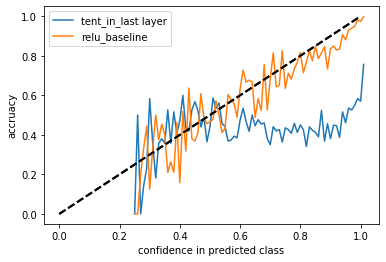

In [61]:
import matplotlib.pyplot as plt

noisy_test = x_test*0.7+np.random.random(np.shape(x_test))*0.3

all_confidences = np.max(model.predict(noisy_test),axis=1)
print("mean confidence", np.mean(all_confidences))
wasit_correct = np.argmax(y_test,axis=1)==np.argmax(model.predict(noisy_test),axis=1)
print("accuracy on noisy test set:", np.mean(wasit_correct))


order = np.argsort(all_confidences)
ordered_confidences = all_confidences[order]
ordered_wasit = wasit_correct[order]

mean_acc=[]
last_idx=0
for i in np.arange(0.16,1.01,0.01):
    stop_idx = np.searchsorted(ordered_confidences,i)
    mean_acc.append(np.mean(ordered_wasit[last_idx:stop_idx]))
    last_idx=stop_idx
    
#print(mean_acc)

plt.figure()
plt.plot(np.arange(0.16,1.01,0.01)+0.01,mean_acc,label="tent_in_last layer")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.ylabel("accruacy")
plt.xlabel("confidence in predicted class")
plt.legend()

#####################

all_confidences = np.max(baseline.predict(noisy_test),axis=1)
print("mean confidence", np.mean(all_confidences))
wasit_correct = np.argmax(y_test,axis=1)==np.argmax(baseline.predict(noisy_test),axis=1)
print("accuracy on noisy test set:", np.mean(wasit_correct))


order = np.argsort(all_confidences)
ordered_confidences = all_confidences[order]
ordered_wasit = wasit_correct[order]

mean_acc=[]
last_idx=0
for i in np.arange(0.16,1.01,0.01):
    stop_idx = np.searchsorted(ordered_confidences,i)
    mean_acc.append(np.mean(ordered_wasit[last_idx:stop_idx]))
    last_idx=stop_idx
    
#print(mean_acc)

plt.plot(np.arange(0.16,1.01,0.01)+0.01,mean_acc,label="relu_baseline")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.ylabel("accruacy")
plt.xlabel("confidence in predicted class")
plt.legend()

plt.show()





baseline relu does not seem so bad, does it? higher accuracy and decent calibration. Do we even have a problem to solve?



# this is CIFAR10 
### This is more interesting than MNIST, because we have similar dataset (cifar100), also, more realistic etc


#THE MODELS BELOW WILL RUN ON CPU!
### TODO: replace model with alexnet architecture
###     1) train baseline without batchnorm
###     2) train basleine with BN
###     3) train tent in all layers (with BN)

In [17]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

from keras.datasets import cifar100
(x100_train, y100_train), (x100_test, y100_test) = cifar100.load_data(label_mode='fine')


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x100_train = x_train.astype('float32')
x100_test = x_test.astype('float32')

#x_train /= 255.0
#x_test /= 255.0
#x100_train /= 255.0
#x100_test /= 255.0
print(np.shape(x100_train),np.shape(x100_test))
print(np.max(x100_train))

(50000, 32, 32, 3) (10000, 32, 32, 3)
255.0


In [14]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 60, 120, 160 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.005
    if epoch > 160:
        lr *=  0.8**3
    elif epoch > 120:
        lr *=  0.8**2
    elif epoch > 60:
        lr *= 0.8
    print('Learning rate: ', lr)
    return lr


lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [lr_scheduler]

In [15]:
import networks
baseline_wnn= networks.WideResidualNetwork(width=10)

In [16]:
import numpy as np
for lay in baseline_wnn.layers:
    if "theta_initializer" in lay.get_config():
        print(np.shape(lay.get_weights()))
        print(lay.get_weights())


output = baseline_wnn.predict(np.expand_dims(np.random.random(x_train.shape[1:]),0))
print("should be random (/uniform):  ", output)

should be random (/uniform):   [[0.00558265 0.2346106  0.02837992 0.07606066 0.19645056 0.05116265
  0.05004261 0.18317674 0.05850454 0.11602917]]


In [17]:
import keras
import numpy as np
from keras import backend as K

from keras.layers import Layer
from keras.layers import activations
from keras.layers import initializers
from keras.layers import regularizers
from keras.layers import constraints


from keras.utils import to_categorical

print(baseline_wnn.summary())

baseline_wnn.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.1,decay=0.0005, momentum=0.9),
              metrics=['accuracy'])

data_augmentation = True

if not data_augmentation:
    baseline_wnn.fit(x_train, to_categorical(y_train), batch_size=100, epochs=200, validation_data=(x_test, to_categorical(y_test)), shuffle=True,callbacks=callbacks)
    

else:
    from keras.preprocessing.image import ImageDataGenerator
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    baseline_wnn.fit_generator(datagen.flow(x_train, to_categorical(y_train),
                                     batch_size=100),
                        epochs=200, steps_per_epoch=500,
                        validation_data=(x_test, to_categorical(y_test)),
                        workers=4, callbacks=callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 32, 32, 16)   64          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 32, 32, 16)   0           batch_normalization_51[0][0]     
__________________________________________________________________________________________________
conv2d_59 

Epoch 1/200
Learning rate:  0.005
500/500 [==============================] - 251s 503ms/step - loss: 3.0241 - acc: 0.3288 - val_loss: 2.1859 - val_acc: 0.3225
Epoch 2/200
Learning rate:  0.005
500/500 [==============================] - 250s 499ms/step - loss: 1.4699 - acc: 0.5104 - val_loss: 1.4678 - val_acc: 0.5208
Epoch 3/200
Learning rate:  0.005
500/500 [==============================] - 241s 482ms/step - loss: 1.1418 - acc: 0.6209 - val_loss: 1.0250 - val_acc: 0.6407
Epoch 4/200
Learning rate:  0.005
500/500 [==============================] - 240s 479ms/step - loss: 0.8431 - acc: 0.7046 - val_loss: 1.1425 - val_acc: 0.6255
Epoch 5/200
Learning rate:  0.005
500/500 [==============================] - 241s 482ms/step - loss: 0.6885 - acc: 0.7571 - val_loss: 0.7862 - val_acc: 0.7408
Epoch 6/200
Learning rate:  0.005
500/500 [==============================] - 249s 497ms/step - loss: 0.5937 - acc: 0.7916 - val_loss: 0.6586 - val_acc: 0.7748
Epoch 7/200
Learning rate:  0.005
500/500 [===

500/500 [==============================] - 240s 480ms/step - loss: 0.0082 - acc: 0.9982 - val_loss: 0.4868 - val_acc: 0.8912
Epoch 104/200
Learning rate:  0.004
500/500 [==============================] - 240s 480ms/step - loss: 0.0080 - acc: 0.9983 - val_loss: 0.4614 - val_acc: 0.8954
Epoch 105/200
Learning rate:  0.004
500/500 [==============================] - 240s 480ms/step - loss: 0.0081 - acc: 0.9984 - val_loss: 0.4680 - val_acc: 0.8937
Epoch 106/200
Learning rate:  0.004
500/500 [==============================] - 240s 480ms/step - loss: 0.0077 - acc: 0.9985 - val_loss: 0.4688 - val_acc: 0.8958
Epoch 107/200
Learning rate:  0.004
500/500 [==============================] - 240s 480ms/step - loss: 0.0082 - acc: 0.9981 - val_loss: 0.4608 - val_acc: 0.8960
Epoch 108/200
Learning rate:  0.004
500/500 [==============================] - 240s 480ms/step - loss: 0.0073 - acc: 0.9985 - val_loss: 0.5056 - val_acc: 0.8903
Epoch 109/200
Learning rate:  0.004
500/500 [=========================

500/500 [==============================] - 240s 480ms/step - loss: 0.0055 - acc: 0.9989 - val_loss: 0.4705 - val_acc: 0.8982
Epoch 152/200
Learning rate:  0.0032000000000000006
500/500 [==============================] - 240s 480ms/step - loss: 0.0052 - acc: 0.9991 - val_loss: 0.4771 - val_acc: 0.8974
Epoch 153/200
Learning rate:  0.0032000000000000006
500/500 [==============================] - 240s 480ms/step - loss: 0.0055 - acc: 0.9988 - val_loss: 0.4705 - val_acc: 0.8985
Epoch 154/200
Learning rate:  0.0032000000000000006
500/500 [==============================] - 240s 480ms/step - loss: 0.0054 - acc: 0.9990 - val_loss: 0.4745 - val_acc: 0.8989
Epoch 155/200
Learning rate:  0.0032000000000000006
500/500 [==============================] - 240s 480ms/step - loss: 0.0054 - acc: 0.9990 - val_loss: 0.4786 - val_acc: 0.8959
Epoch 156/200
Learning rate:  0.0032000000000000006
500/500 [==============================] - 240s 480ms/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.4746 - val_ac

In [18]:
for lay in baseline_wnn.layers:
    if "theta_initializer" in lay.get_config():
        print(np.shape(lay.get_weights()))
        print(lay.get_weights())

In [19]:
print("baseline_wnn mean confidence on train data ",np.mean(np.max(baseline_wnn.predict(x_train),axis=1)))
print("baseline_wnn mean confidence on test data ",np.mean(np.max(baseline_wnn.predict(x_test),axis=1)))

print("\n\n")

ran = np.random.random(size=(100,32,32,3))*255

print("baseline_wnn mean confidence on random matrix ",np.mean(np.max(baseline_wnn.predict(ran),axis=1)))

flat_gray=np.ones((100,32,32,3))*128
print("baseline_wnn mean confidence on flat_gray img ",np.mean(np.max(baseline_wnn.predict(flat_gray),axis=1)))

avg_img = np.mean(x_test, axis=0,keepdims=True)
#print(np.shape(avg_img))
print("baseline_wnn mean confidence on avg_img ",np.mean(np.max(baseline_wnn.predict(avg_img),axis=1)))

baseline_wnn mean confidence on train data  0.99780244
baseline_wnn mean confidence on test data  0.9662047



baseline_wnn mean confidence on random matrix  0.88714707
baseline_wnn mean confidence on flat_gray img  0.6624398
baseline_wnn mean confidence on avg_img  0.78461957


In [20]:
counts = np.bincount(np.argmax(baseline_wnn.predict(ran),axis=1)) 
names = ["plane","car","bird","cat","deer","dog","frog","horse", "ship","truck"]
for i in np.argsort(counts):
    print(names[i], ":", counts[i])

car : 0
deer : 0
dog : 0
plane : 1
cat : 1
frog : 19
bird : 79


In [30]:
cifar100preds = baseline_wnn.predict(x100_test)
print("tent mean confidence on cifar100 ",np.mean(np.max(cifar100preds,axis=1)))
#print(cifar100preds[:10])

tent mean confidence on cifar100  0.9234621


In [39]:
baseline_28_1 = baseline_wnn
#baseline results 28-1

"""
 acc: 0.9483 - val_loss: 0.4382 - val_acc: 0.8689

tent mean confidence on cifar100  0.9234621

baseline_wnn mean confidence on train data  0.944834
baseline_wnn mean confidence on test data  0.9234621



baseline_wnn mean confidence on random matrix  0.913423
baseline_wnn mean confidence on flat_gray img  0.9578364
baseline_wnn mean confidence on avg_img  0.77367663

"""

NameError: name 'baseline_wnn' is not defined

254.99985038451163
mean confidence 0.878901
accuracy on noisy test set: 0.0747


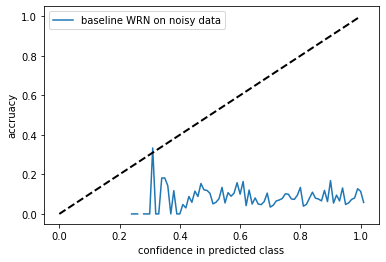

In [37]:
import matplotlib.pyplot as plt

noisy_test = x_test*0.9+np.random.random(np.shape(x_test))*0.1*255

print(np.max(noisy_test))

all_confidences = np.max(baseline_wnn.predict(noisy_test),axis=1)
print("mean confidence", np.mean(all_confidences))
wasit_correct = np.argmax(y_test,axis=1)==np.argmax(baseline_wnn.predict(noisy_test),axis=1)
print("accuracy on noisy test set:", np.mean(wasit_correct))


order = np.argsort(all_confidences)
ordered_confidences = all_confidences[order]
ordered_wasit = wasit_correct[order]

mean_acc=[]
last_idx=0
for i in np.arange(0.16,1.01,0.01):
    stop_idx = np.searchsorted(ordered_confidences,i)
    mean_acc.append(np.mean(ordered_wasit[last_idx:stop_idx]))
    last_idx=stop_idx
    
#print(mean_acc)

plt.figure()
plt.plot(np.arange(0.16,1.01,0.01)+0.01,mean_acc,label="baseline WRN on noisy data")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.ylabel("accruacy")
plt.xlabel("confidence in predicted class")
plt.legend()
plt.show()

# WRN-28-1 With TENT

In [31]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

from keras.datasets import cifar100
(x100_train, y100_train), (x100_test, y100_test) = cifar100.load_data(label_mode='fine')


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x100_train = x_train.astype('float32')
x100_test = x_test.astype('float32')

#x_train /= 255.0
#x_test /= 255.0
#x100_train /= 255.0
#x100_test /= 255.0
print(np.shape(x100_train),np.shape(x100_test))
print(np.max(x100_train))

(50000, 32, 32, 3) (10000, 32, 32, 3)
255.0


In [32]:
import networks
tent_wnn= networks.WideResidualNetworkWithTent(width=10,tent_regularizer=0.004)

for lay in tent_wnn.layers:
    if "theta_initializer" in lay.get_config():
        print(np.shape(lay.get_weights()))
        print(lay.get_weights())


output = tent_wnn.predict(np.expand_dims(np.random.random(x_train.shape[1:]),0))
print("should be random (/uniform):  ", output)

(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtype=float32)]
(1, 1, 1, 1)
[array([[[1.]]], dtyp

In [33]:
print(tent_wnn.summary())

tent_wnn.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

data_augmentation = True

if not data_augmentation:
    tent_wnn.fit(x_train, to_categorical(y_train), batch_size=100, epochs=200, validation_data=(x_test, to_categorical(y_test)), shuffle=True,callbacks=callbacks)
    

else:
    from keras.preprocessing.image import ImageDataGenerator
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    tent_wnn.fit_generator(datagen.flow(x_train, to_categorical(y_train),
                                     batch_size=100),
                        epochs=200, steps_per_epoch=500,
                        validation_data=(x_test, to_categorical(y_test)),
                        workers=4, callbacks=callbacks)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 32, 32, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_126 (BatchN (None, 32, 32, 16)   64          conv2d_136[0][0]                 
__________________________________________________________________________________________________
tent_126 (Tent)                 (None, 32, 32, 16)   1           batch_normalization_126[0][0]    
__________________________________________________________________________________________________
conv2d_138

Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.001
500/500 [==============================] - 324s 648ms/step - loss: 5.3440 - acc: 0.2428 - val_loss: 2.6619 - val_acc: 0.1253
Epoch 2/200
Learning rate:  0.001
500/500 [==============================] - 307s 614ms/step - loss: 1.6914 - acc: 0.4174 - val_loss: 2.6407 - val_acc: 0.1047
Epoch 3/200
Learning rate:  0.001
500/500 [==============================] - 307s 614ms/step - loss: 1.5469 - acc: 0.4722 - val_loss: 4.2700 - val_acc: 0.1201
Epoch 4/200
Learning rate:  0.001
500/500 [==============================] - 307s 614ms/step - loss: 1.4587 - acc: 0.5045 - val_loss: 2.7104 - val_acc: 0.1573
Epoch 5/200
Learning rate:  0.001
500/500 [==============================] - 307s 613ms/step - loss: 1.3850 - acc: 0.5296 - val_loss: 2.9757 - val_acc: 0.1098
Epoch 6/200
Learning rate:  0.001
500/500 [==============================] - 307s 613ms/step - loss: 1.3254 - acc: 0.5514 - val_loss: 2.3164 - val_acc: 0.2135
Epoch 7/200

500/500 [==============================] - 291s 582ms/step - loss: 0.3774 - acc: 0.8796 - val_loss: 1.1828 - val_acc: 0.6745
Epoch 53/200
Learning rate:  0.001
500/500 [==============================] - 291s 582ms/step - loss: 0.3588 - acc: 0.8872 - val_loss: 1.0283 - val_acc: 0.6968
Epoch 54/200
Learning rate:  0.001
500/500 [==============================] - 291s 582ms/step - loss: 0.3070 - acc: 0.9049 - val_loss: 1.2005 - val_acc: 0.6697
Epoch 55/200
Learning rate:  0.001
500/500 [==============================] - 291s 582ms/step - loss: 0.3187 - acc: 0.9013 - val_loss: 0.8995 - val_acc: 0.7303
Epoch 56/200
Learning rate:  0.001
500/500 [==============================] - 291s 582ms/step - loss: 0.3279 - acc: 0.8971 - val_loss: 0.8910 - val_acc: 0.7340
Epoch 57/200
Learning rate:  0.001
500/500 [==============================] - 291s 582ms/step - loss: 0.2886 - acc: 0.9116 - val_loss: 0.8655 - val_acc: 0.7458
Epoch 58/200
Learning rate:  0.001
500/500 [==============================]

500/500 [==============================] - 291s 582ms/step - loss: 0.1226 - acc: 0.9696 - val_loss: 0.9792 - val_acc: 0.7808
Epoch 104/200
Learning rate:  0.0008
500/500 [==============================] - 291s 582ms/step - loss: 0.1272 - acc: 0.9674 - val_loss: 1.1195 - val_acc: 0.7409
Epoch 105/200
Learning rate:  0.0008
500/500 [==============================] - 291s 582ms/step - loss: 0.2198 - acc: 0.9383 - val_loss: 1.1350 - val_acc: 0.7183
Epoch 106/200
Learning rate:  0.0008
500/500 [==============================] - 291s 582ms/step - loss: 0.2575 - acc: 0.9233 - val_loss: 1.2496 - val_acc: 0.6784
Epoch 107/200
Learning rate:  0.0008
500/500 [==============================] - 291s 582ms/step - loss: 0.1904 - acc: 0.9463 - val_loss: 1.0819 - val_acc: 0.7526
Epoch 108/200
Learning rate:  0.0008
500/500 [==============================] - 291s 582ms/step - loss: 0.1833 - acc: 0.9480 - val_loss: 1.1298 - val_acc: 0.7364
Epoch 109/200
Learning rate:  0.0008
500/500 [===================

500/500 [==============================] - 291s 582ms/step - loss: 0.0853 - acc: 0.9821 - val_loss: 1.2880 - val_acc: 0.7481
Epoch 152/200
Learning rate:  0.0006400000000000002
500/500 [==============================] - 291s 582ms/step - loss: 0.1046 - acc: 0.9758 - val_loss: 1.0685 - val_acc: 0.7731
Epoch 153/200
Learning rate:  0.0006400000000000002
500/500 [==============================] - 291s 582ms/step - loss: 0.1062 - acc: 0.9740 - val_loss: 1.2071 - val_acc: 0.7536
Epoch 154/200
Learning rate:  0.0006400000000000002
500/500 [==============================] - 291s 582ms/step - loss: 0.0990 - acc: 0.9770 - val_loss: 1.1158 - val_acc: 0.7724
Epoch 155/200
Learning rate:  0.0006400000000000002
500/500 [==============================] - 291s 582ms/step - loss: 0.0907 - acc: 0.9805 - val_loss: 1.3021 - val_acc: 0.7408
Epoch 156/200
Learning rate:  0.0006400000000000002
500/500 [==============================] - 291s 582ms/step - loss: 0.0973 - acc: 0.9777 - val_loss: 1.3840 - val_ac

In [34]:
for lay in tent_wnn.layers:
    if "theta_initializer" in lay.get_config():
        #print(np.shape(lay.get_weights()))
        print(lay.get_weights()[0])


[[[0.45240587]]]
[[[0.42183113]]]
[[[0.05019424]]]
[[[0.31066635]]]
[[[0.06147592]]]
[[[0.4985551]]]
[[[0.06201436]]]
[[[0.4171327]]]
[[[0.06730621]]]
[[[0.10366999]]]
[[[0.05]]]
[[[0.12733164]]]
[[[0.05649449]]]
[[[0.7183297]]]
[[[0.7067606]]]
[[[0.0659201]]]
[[[0.05]]]
[[[0.62916434]]]
[[[0.9998009]]]
[[[0.62269974]]]
[[[0.9999301]]]
[[[0.7188164]]]
[[[0.90166104]]]
[[[0.42692164]]]
[[[0.92941064]]]


In [35]:
print("tent_wnn mean confidence on train data ",np.mean(np.max(tent_wnn.predict(x_train),axis=1)))
print("tent_wnn mean confidence on test data ",np.mean(np.max(tent_wnn.predict(x_test),axis=1)))

print("\n\n")

ran = np.random.random(size=(100,32,32,3))*255

print("tent_wnn mean confidence on random matrix ",np.mean(np.max(tent_wnn.predict(ran),axis=1)))

flat_gray=np.ones((100,32,32,3))*128
print("tent_wnn mean confidence on flat_gray img ",np.mean(np.max(tent_wnn.predict(flat_gray),axis=1)))

avg_img = np.mean(x_test, axis=0,keepdims=True)
#print(np.shape(avg_img))
print("tent_wnn mean confidence on avg_img ",np.mean(np.max(tent_wnn.predict(avg_img),axis=1)))

tent_wnn mean confidence on train data  0.9732332
tent_wnn mean confidence on test data  0.9314898



tent_wnn mean confidence on random matrix  0.8055158
tent_wnn mean confidence on flat_gray img  0.59138983
tent_wnn mean confidence on avg_img  0.61460364


In [36]:
cifar100preds = tent_wnn.predict(x100_test)
print("tent mean confidence on cifar100 ",np.mean(np.max(cifar100preds,axis=1)))
#print(cifar100preds[:10])

tent mean confidence on cifar100  0.9314898


In [37]:
wnn_28_10 = tent_wnn